In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch 
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import pandas as pd 


In [2]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("GPU is available")
else:
    print("GPU is not available")


GPU is available


In [3]:
data_dir = "../input/intel-image-classification" 
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

num_workers = 0
batch_size = 30

valid_size = 0.2


train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.2),
                                      transforms.RandomRotation(10),
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])



train_data = datasets.ImageFolder(data_dir + "/seg_train/seg_train", transform = train_transform)
test_data = datasets.ImageFolder(data_dir + "/seg_test/seg_test", transform = test_transform)

lotrainLoader = len(train_data)
indices = list(range(lotrainLoader))
np.random.shuffle(indices)

split = int(np.floor(valid_size * lotrainLoader))
train_idx = indices[split:]
valid_idx = indices[:split]

train_sample = SubsetRandomSampler(train_idx)
valid_sample = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, sampler = train_sample)
validloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, sampler = valid_sample) 
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)



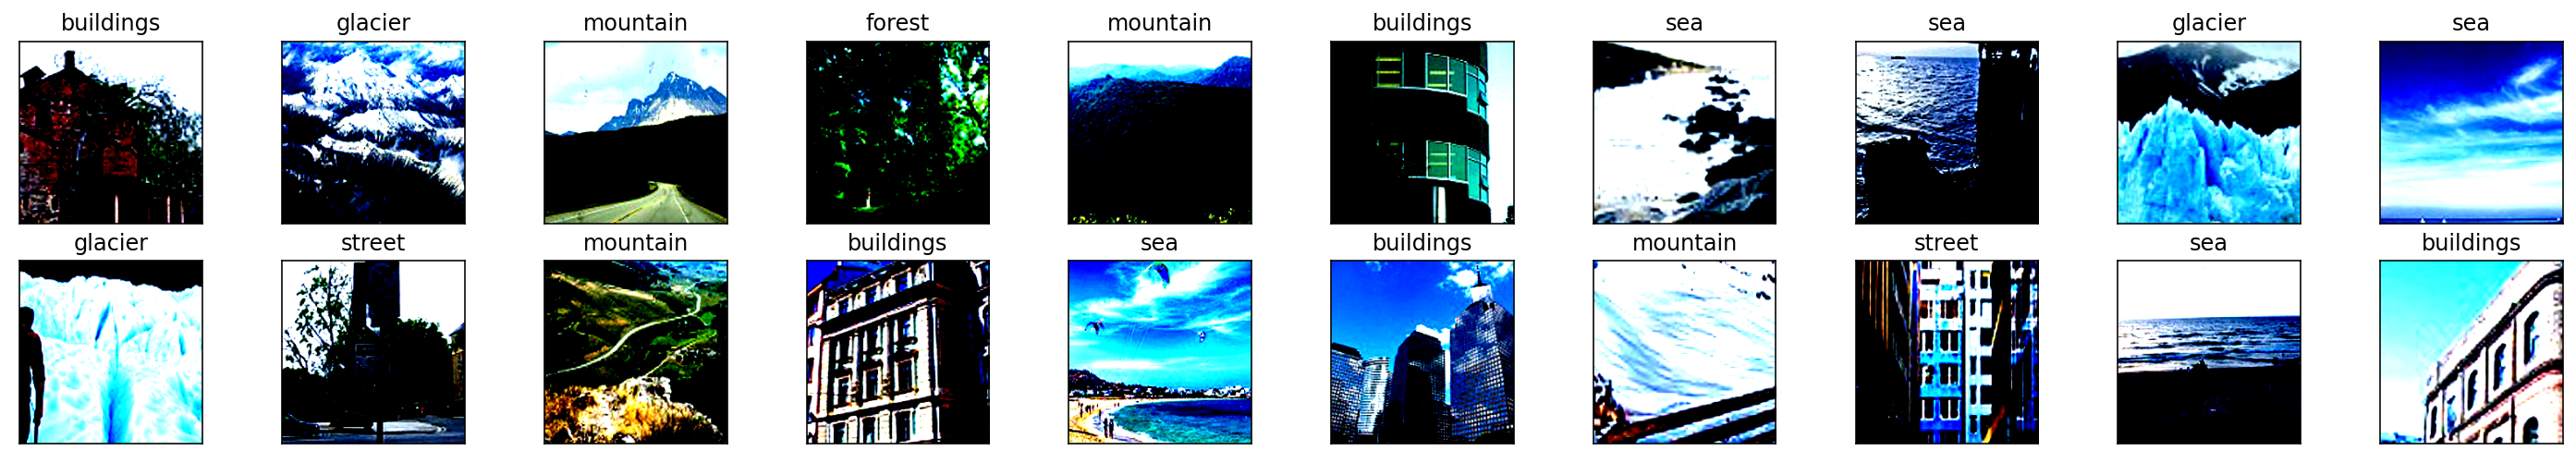

In [4]:

dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.numpy()


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])



In [5]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

**This Should Use Transfer Learning from an already pretrained VGG16 model**

In [6]:
for param in vgg16.features.parameters():
    param.requires_grad = False

In [7]:

vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, len(classes))
print(vgg16.classifier)

if train_on_gpu:
    vgg16.cuda()


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=6, bias=True)
)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr = 0.003)

In [9]:
epochs = 6

for epoch in range(epochs):
    training_loss = 0
    validation_loss = 0
    for batch_i, (images, labels) in enumerate(trainloader):
        
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        output = vgg16(images)
        
        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()
        training_loss += loss.item()
        
    
    for batch_i, (images, labels) in enumerate(validloader):
        
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        output = vgg16(images)
        
        loss = criterion(output, labels)
        validation_loss += loss.item()
        
    print("Validation Loss: ", validation_loss)
    print("Training Loss: ", training_loss)

    

            

Validation Loss:  351.93127232789993
Training Loss:  1035.623486161232
Validation Loss:  249.06501281261444
Training Loss:  967.1679714620113
Validation Loss:  225.856867313385
Training Loss:  834.9443013966084
Validation Loss:  173.55436339974403
Training Loss:  628.4680625498295
Validation Loss:  194.21593916416168
Training Loss:  574.087283372879
Validation Loss:  154.32271325588226
Training Loss:  619.2865527272224


In [14]:
test_loss = 0

vgg16.eval()
for batch_i, (images, labels) in enumerate(testloader):
    
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    
    output = vgg16(images)
    loss = criterion(output, labels)
    
    test_loss += loss.item()

test_loss = test_loss / len(testloader.dataset)
print("Average Test Loss", test_loss)


Average Test Loss 0.020757314532995223


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

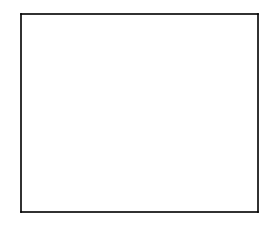

In [28]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(25, 4))
images = images.cpu()
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
    